## Importing necessary libraries

In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-dataset-from-cardekho/car data.csv
/kaggle/input/vehicle-dataset-from-cardekho/CAR DETAILS FROM CAR DEKHO.csv
/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv


In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

In [94]:
#read the csv file
df = pd.read_csv("/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv")

In [95]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


## Data preprocessing

#### Adding column 'brand'.
The brand value of the car is important in resale. Extracting the brand name from car name and creating a new column for brand name

In [96]:
df['brand'] = 0
for i in df.name.index:
    df.loc[i,['brand']] = df.name[i].split()[0]

In [97]:
#Torque is calculated using the bhp and directly proportional to the bhp. We can remove the column torque
df = df.drop(['torque'],axis =1)

#### Remove the units from the column values and convert to numeric

In [98]:
df.mileage = df.mileage.str.replace("kmpl","")
df.mileage = df.mileage.str.replace("km/kg","")
df.engine = df.engine.str.replace("CC","")
df.max_power =df.max_power.str.replace(" bhp","")

In [99]:
df[['mileage','engine','max_power']] = df[['mileage','engine','max_power']].apply(pd.to_numeric)

### Handling the zero and null values

In [100]:
#there are outiers in the data. mileage and max_power can't be zero. Let's see if we can fix these values.
df['mileage'] = df['mileage'].replace({'0':np.nan, 0:np.nan})
df['max_power'] = df['max_power'].replace({'0':np.nan, 0:np.nan})

In [101]:
#extract the rows with null values to dfnew
dfnew = df[df.isna().any(axis=1)]
#remove these rows from main df for below processing. We'll add them back.
df = df.dropna()

In [102]:
#many of these null row cars are already there in the dataset. The details such as mileage, engine, max_power and seats will be
#same for cars with same model details.
for i in dfnew.index:
    for j in df.index:
        if (dfnew.loc[i,'name'] == df.loc[j,'name']):
            dfnew.loc[i,'mileage'] = df.loc[j,'mileage']
            dfnew.loc[i,'engine'] = df.loc[j,'engine']
            dfnew.loc[i,'max_power'] = df.loc[j,'max_power']
            dfnew.loc[i,'seats'] = df.loc[j,'seats']
            break

#there is no efficient way to get the correct values for the rest of null values. dropping them.
dfnew = dfnew.dropna()
#merge back the new non null values
df = pd.concat([df, dfnew])

In [103]:
#result
#mileage, engine, max_power, seats has been filled correctly for 1442.

df[(df.name == 'Maruti Swift Dzire VDI Optional' )]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand
2626,Maruti Swift Dzire VDI Optional,2015,525000,80000,Diesel,Individual,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti
3163,Maruti Swift Dzire VDI Optional,2017,589000,41232,Diesel,Dealer,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti
3231,Maruti Swift Dzire VDI Optional,2017,675000,35000,Diesel,Individual,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti
3818,Maruti Swift Dzire VDI Optional,2016,690000,80000,Diesel,Individual,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti
4673,Maruti Swift Dzire VDI Optional,2018,690000,52200,Diesel,Dealer,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti
5944,Maruti Swift Dzire VDI Optional,2017,589000,41232,Diesel,Dealer,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti
6275,Maruti Swift Dzire VDI Optional,2018,751000,44885,Diesel,Dealer,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti
1442,Maruti Swift Dzire VDI Optional,2017,589000,41232,Diesel,Dealer,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti
1443,Maruti Swift Dzire VDI Optional,2017,589000,41232,Diesel,Dealer,Manual,First Owner,26.59,1248.0,74.0,5.0,Maruti


## Duplicate removal
This dataset contains a good number of duplicate rows. This will affect the model accuracy. Removing that first.

In [104]:
print("Total number of rows : ",len(df))
print("No of duplicate rows: ",len(df[df.duplicated()]))
df = df.drop_duplicates()
print("No of rows after duplicate removal : ",len(df))

Total number of rows :  7950
No of duplicate rows:  1193
No of rows after duplicate removal :  6757


## Splitting data
Keep the Test data isolated and use only on the final model.
Keep the validation data isolated until EDA and feature engineering is done. These should be based on the training data only.

We'll drop the columns 'name' and 'selling_price' after the splitting. Because we need those columns during numerical conversion 
based on training data in feature engineering. (can be dropped from x_valid and x_test because we won't be using those data for deciding weightage )

In [105]:
X = df
y = df.selling_price
#train validation test split
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.12)
X_train , X_valid, y_train, y_valid = train_test_split(X_train , y_train, test_size=0.14)
print(len(X_train),len(X_valid),len(X_test))

5113 833 811


In [106]:
#categorical variables to find the order of data.
catgvars = ['year','fuel', 'seller_type','transmission', 'owner','brand']
numvars = ['km_driven','mileage','engine','max_power','seats']

In [107]:
# Check if any category value is missing in the training data. If yes include that in X_train. 
# There are few that appears only once in dataset and if it's not in training, it won't get the weightage. 
# We need to train with all categories possible.
for cat in catgvars:
    setofMissing = set.difference(set(df[cat].unique()) - set(X_train[cat].unique()))
    print(cat, len(setofMissing))
    for miss in setofMissing:
        X_train = pd.concat([X_train, df[df[cat] == miss ]])
        y_train = pd.concat([y_train, df[df[cat] == miss ].selling_price])

year 1
fuel 0
seller_type 0
transmission 0
owner 0
brand 0


## EDA

Text(0, 0.5, 'selling_price')

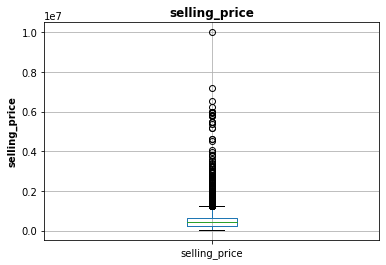

In [108]:
X_train.boxplot(column=['selling_price']) ;
plt.title('selling_price', fontweight='bold');
plt.ylabel("selling_price", fontweight='bold')

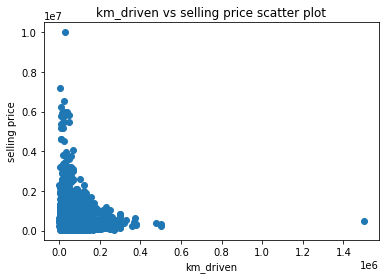

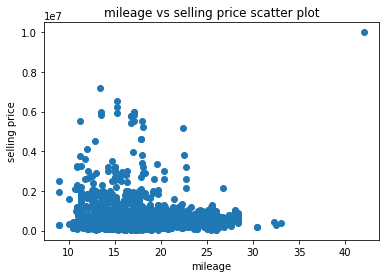

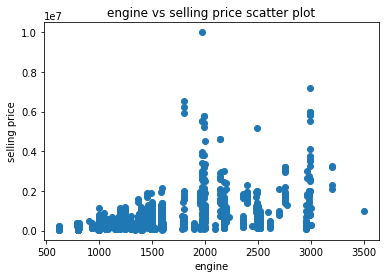

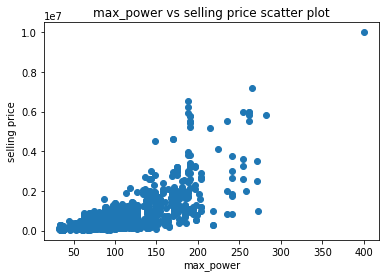

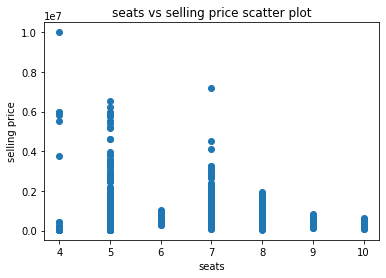

In [109]:
for nvar in numvars:
    plt.scatter(X_train[nvar], X_train.selling_price)
    plt.title(nvar+" vs selling price scatter plot")
    plt.ylabel("selling price")
    plt.xlabel(nvar)
    plt.show()

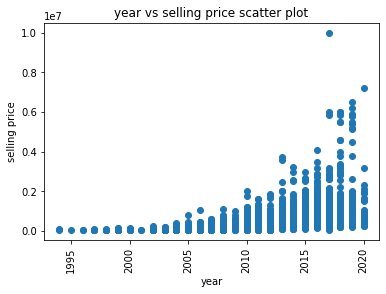

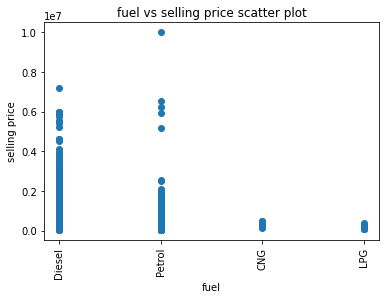

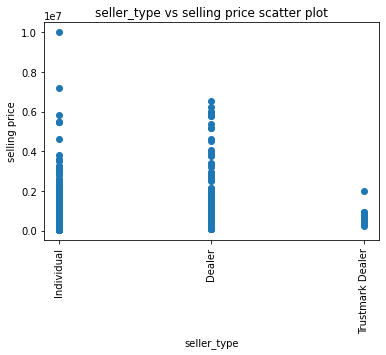

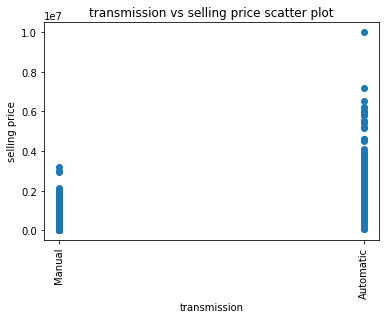

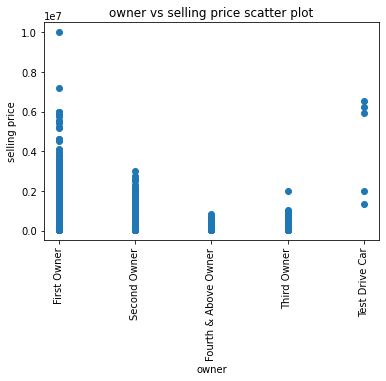

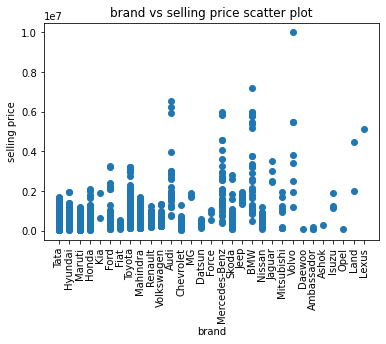

In [110]:
for cvar in catgvars:
    plt.scatter(X_train[cvar], X_train.selling_price)
    plt.title(cvar+" vs selling price scatter plot")
    plt.ylabel("selling price")
    plt.xlabel(cvar)
    plt.xticks(rotation=90)
    plt.show()

## Observations

* There are outliers in selling_price and we should use the median of the selling price for feature engineering.
* As expected, as the engine power increases price increases
* The older the car is, the lesser the value.
* Most demand is for Diesel and Petrol cars. Also automatic cars costs are much higher than manual transmission.
* Higher the price if number of owners before is one.

## Feature Engineering
Here we need to convert the categorical variables to numerical data using appropriate weight values.
For this , for each categorical variable value, I'm using the mean of selling price. Then I'll sort it by order of their means.
Then Weight is given from 1 to last.

The weights for each categorical column values is created using training data only.

In [111]:
#Below dictionary will contain catg varaible name and dictionary of weightage mappings as value.
dict_cat_dictv = {}

#Create this data using the X_train data only to keep the model integrity.
for cat in catgvars:
    dfnew = X_train.groupby([cat]).median()
    dfnew = dfnew.sort_values('selling_price')
    
    #dictionary of weights initialization.
    dict_v = {}
    
    #save the value as dictionary item -  'catogorical varaible values' : weightage.
    for i in range(1,1+len(dfnew.index)):
        dict_v[dfnew.index[i-1]] = i
        
    #save the catgorical varaible's weigtage dictionary with key as catgorical varaible name.
    dict_cat_dictv[cat] = dict_v

In [112]:
# convert all data using the numerical values created from X_train alone.
def convertData(df):
    for cat in catgvars:
        df[cat] = df[cat].replace(dict_cat_dictv[cat])
    return df

X_train = convertData(X_train)
X_valid = convertData(X_valid)
X_test = convertData(X_test)

In [113]:
#now that all data is converted. Drop the name and selling_price from the datas.
X_train = X_train.drop(['name','selling_price'],axis=1)
X_valid = X_valid.drop(['name','selling_price'],axis=1)
X_test = X_test.drop(['name','selling_price'],axis=1)

## DecisionTreeRegressor

In [114]:
#to get the maximum depth 
reg_tree = DecisionTreeRegressor(max_depth=i)
reg_tree.fit(X_train , y_train)
md = reg_tree.get_depth()

1 0.4927196892477589 -0.3949393377810613
2 0.4027117157306101 0.3915153156430481
3 0.34853832175983834 0.6107223194787208
4 0.2923671130118086 0.7640607487516858
5 0.24840939081318877 0.8056855425110291
6 0.21800284233167166 0.8442478734579526
7 0.20873689668784046 0.8539251892237982
8 0.1986594053639217 0.8762116559391236
9 0.1880966309700571 0.8749235624956475
10 0.19837012472329751 0.8584643550561369
11 0.19720877701492656 0.880561899068907
12 0.20037028587676087 0.8764519133919929
13 0.1995595041699378 0.872536696078179
14 0.20341325564149038 0.874755305787819
15 0.2095331977647578 0.8750999047615996
16 0.2126166232360067 0.8658211234232559
17 0.21261786345298495 0.866511585499557
18 0.21611574166475572 0.8692368042688103
19 0.2160630656161959 0.8714667095998738
20 0.22191304376566914 0.868042744746039
21 0.21787034128749075 0.8736806951900384
22 0.21684262797230716 0.867754342287014
23 0.21737834091855412 0.8633298958981697
24 0.2214882040516154 0.8631063101262776
25 0.21986450357

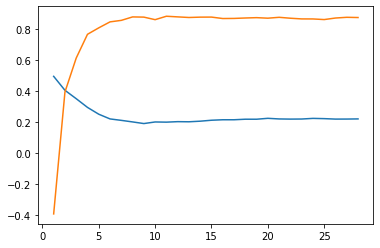

9 11


In [115]:
xg = []
yg = []
zg = []

for i in range(1,md):
    reg_tree = DecisionTreeRegressor(max_depth=i, random_state=10)
    reg_tree.fit(X_train , y_train)
    y_pred = reg_tree.predict(X_valid)
    mape = mean_absolute_percentage_error(y_pred,y_valid)
    r2 = r2_score(y_pred,y_valid)
    print(i, mape, r2)
    xg.append(i)
    yg.append(mape)
    zg.append(r2)
    
plt.plot(xg,yg)
plt.plot(xg,zg)
plt.show()
print(yg.index(min(yg))+1,zg.index(max(zg))+1)

## MODEL 1

In [124]:
reg_treeM1 = DecisionTreeRegressor(max_depth=11, random_state=10)
reg_treeM1.fit(X_train , y_train)
y_pred = reg_treeM1.predict(X_valid)
mape = mean_absolute_percentage_error(y_pred,y_valid)
print(mape)
print(r2_score(y_pred,y_valid))

0.19720877701492656
0.880561899068907


## KNeighborsRegressor

1 0.4325503687318131 0.45280420841623426
2 0.3779409492557428 0.36933222716147873
3 0.36736842488237265 0.153588924217259
4 0.36792219333195836 0.029238556554006312
5 0.36092660184139325 -0.09072471960346906
6 0.36293051676610144 -0.12516812927685672
7 0.36456958153919206 -0.19590794849614568
8 0.3613770683438604 -0.2792097861765974
9 0.3637247248150786 -0.3149202817390311


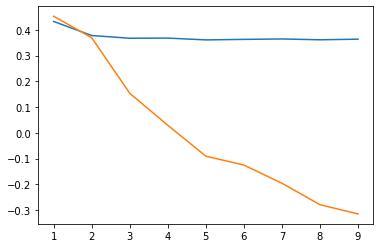

In [117]:
xg=[]
yg=[]
zg=[]
for i in range(1,10):
    reg_k = KNeighborsRegressor(n_neighbors=i)
    reg_k.fit(X_train , y_train)
    y_pred = reg_k.predict(X_valid)
    mape = mean_absolute_percentage_error(y_pred,y_valid)
    r2 = r2_score(y_pred,y_valid)
    print(i, mape, r2)
    xg.append(i)
    yg.append(mape)
    zg.append(r2)
    
plt.plot(xg,yg)
plt.plot(xg,zg)
plt.show()

## Model 2

In [118]:
reg_kM2 = KNeighborsRegressor(n_neighbors=1)
reg_kM2.fit(X_train , y_train)
y_pred = reg_kM2.predict(X_valid)
mape = mean_absolute_percentage_error(y_pred,y_valid)
r2 = r2_score(y_pred,y_valid)
print(mape, r2)

0.4325503687318131 0.45280420841623426


## LinearRegression

In [119]:
from sklearn.linear_model import LinearRegression
reg_l = LinearRegression(fit_intercept=True) 
reg_l.fit(X_train , y_train)
y_pred = reg_k.predict(X_valid)
mape = mean_absolute_percentage_error(y_pred,y_valid)
r2 = r2_score(y_pred,y_valid)
print(mape, r2)

0.3637247248150786 -0.3149202817390311


Both linear regression and KNeighborsRegressor doesn't work well with the data. Where as decision tree regressor is giving very good results

## Coclusion
Model 1 with Decison Tree regressor is the one we're going with for the actual Test data.

## FINAL testing with TEST data.
We didnt use this data at any stage of EDA or model validation.

In [125]:
y_test_pred = reg_treeM1.predict(X_test)
mape = mean_absolute_percentage_error(y_test_pred,y_test)
print('Mean absolute percentage error: ',mape)
print('R2 value:' ,r2_score(y_test_pred,y_test))

Mean absolute percentage error:  0.19516504704777304
R2 value: 0.882142988078284
